In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import OrderedDict
from os.path import join
from deepburtsev.core.pipeline_manager import PipelineManager
from deepburtsev.core.datasets.dataset_readers import read_sber_dataset

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


2018-04-19 19:03:26.403 WARNING in 'tensorflow'['tf_logging'] at line 126: From /home/mks/envs/intent_script/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.
2018-04-19 19:03:26.719 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


В корневой папке создаёшь такое вот дерево 
./data/russian/embeddings/"сюда эмбеддинг кладёшь"
                         /"имя датасета"/"сюда файлик"

In [2]:
root = '/home/mks/projects/DeepBurtsev/'
language = 'russian'
dataset_name = 'sber'
file_name = 'sber.csv'
emb_name = 'ft_native_300_ru_wiki_lenta_nltk_word_tokenize.bin'
emb_dim = 300

file_path = join(root, 'data', language, dataset_name, 'data', file_name)
pure_data = read_sber_dataset(file_path)

In [3]:
neural_struct = {'Lemmatizer': [False, True], 'model': ['CNN']}
neural_pipe = OrderedDict(Tokenizer=True,
                          Lemmatizer=True,
                          vectorizer='FasttextVectorizer',
                          model='CNN',
                          Resulter='Resulter')

linear_struct = {'Lemmatizer': [False, True],
                 'vectorizer': ['tf-idf', 'count'],
                 'model': ['LogisticRegression']}
# 'model': ['LogisticRegression',
#           'RandomForestClassifier',
#           'LGBMClassifier',
#           'LinearSVC']}
linear_pipe = OrderedDict(Tokenizer=True,
                          Lemmatizer=True,
                          Textсoncatenator=True,
                          vectorizer='tf-idf',
                          model='LogisticRegression',
                          Resulter='Resulter')

linear
/home/mks/projects/DeepBurtsev/
linear
/home/mks/projects/DeepBurtsev/


2018-04-19 19:03:31.311 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 16: Loading dictionaries from /home/mks/envs/intent_script/lib/python3.6/site-packages/pymorphy2_dicts/data
2018-04-19 19:03:31.338 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 20: format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


linear
/home/mks/projects/DeepBurtsev/


2018-04-19 19:03:33.229 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 16: Loading dictionaries from /home/mks/envs/intent_script/lib/python3.6/site-packages/pymorphy2_dicts/data


linear
/home/mks/projects/DeepBurtsev/


2018-04-19 19:03:33.314 INFO in 'pymorphy2.opencorpora_dict.wrapper'['wrapper'] at line 20: format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


linear
/home/mks/projects/DeepBurtsev/


2018-04-19 19:03:36.154 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-04-19 19:03:36.209 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-04-19 19:03:37.304 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-04-19 19:03:37.62

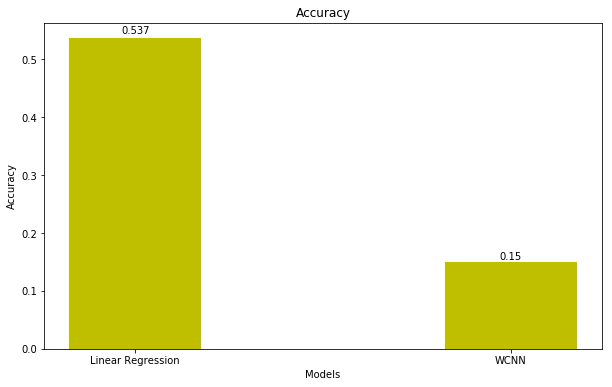

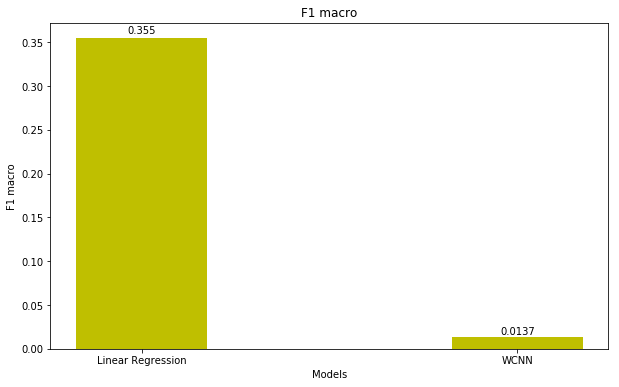

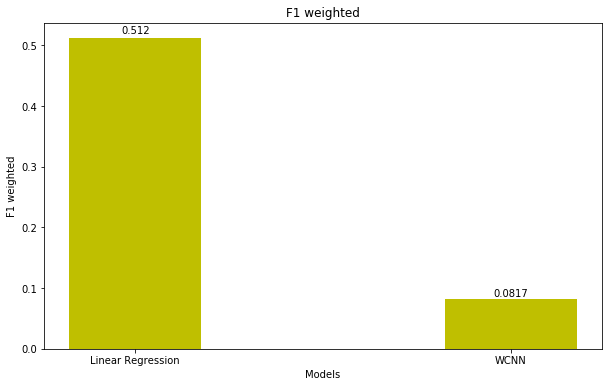

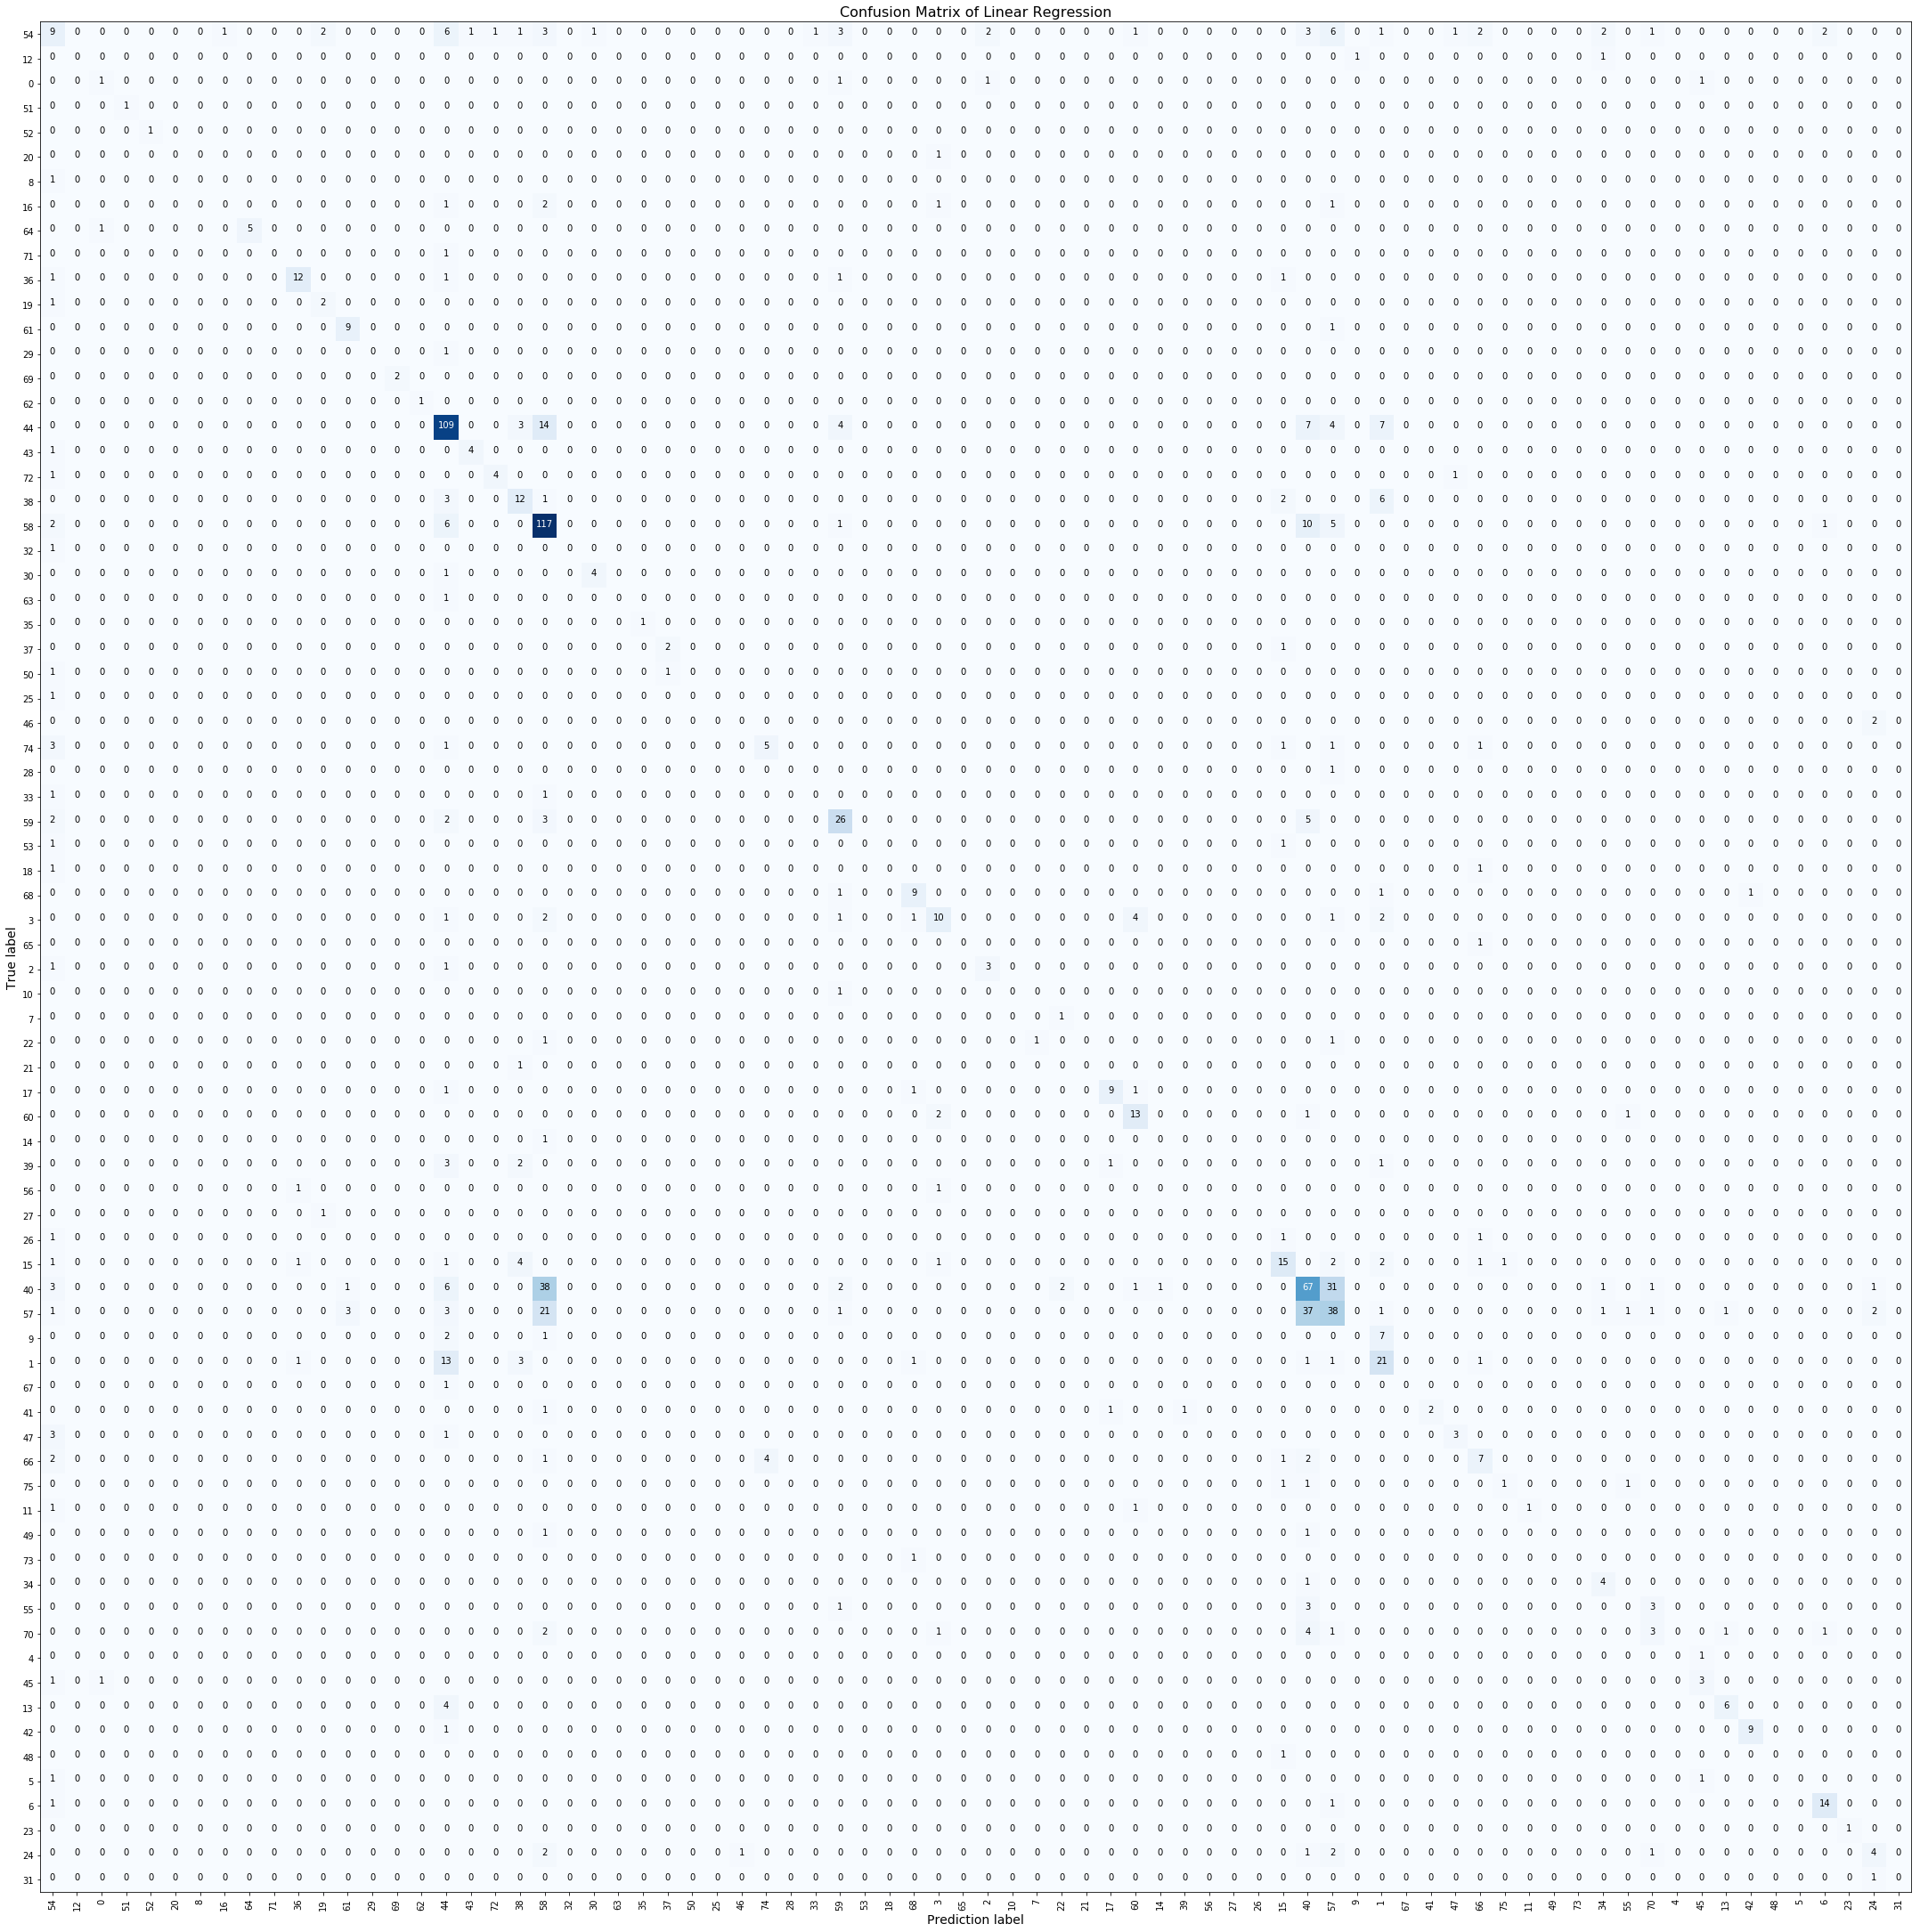

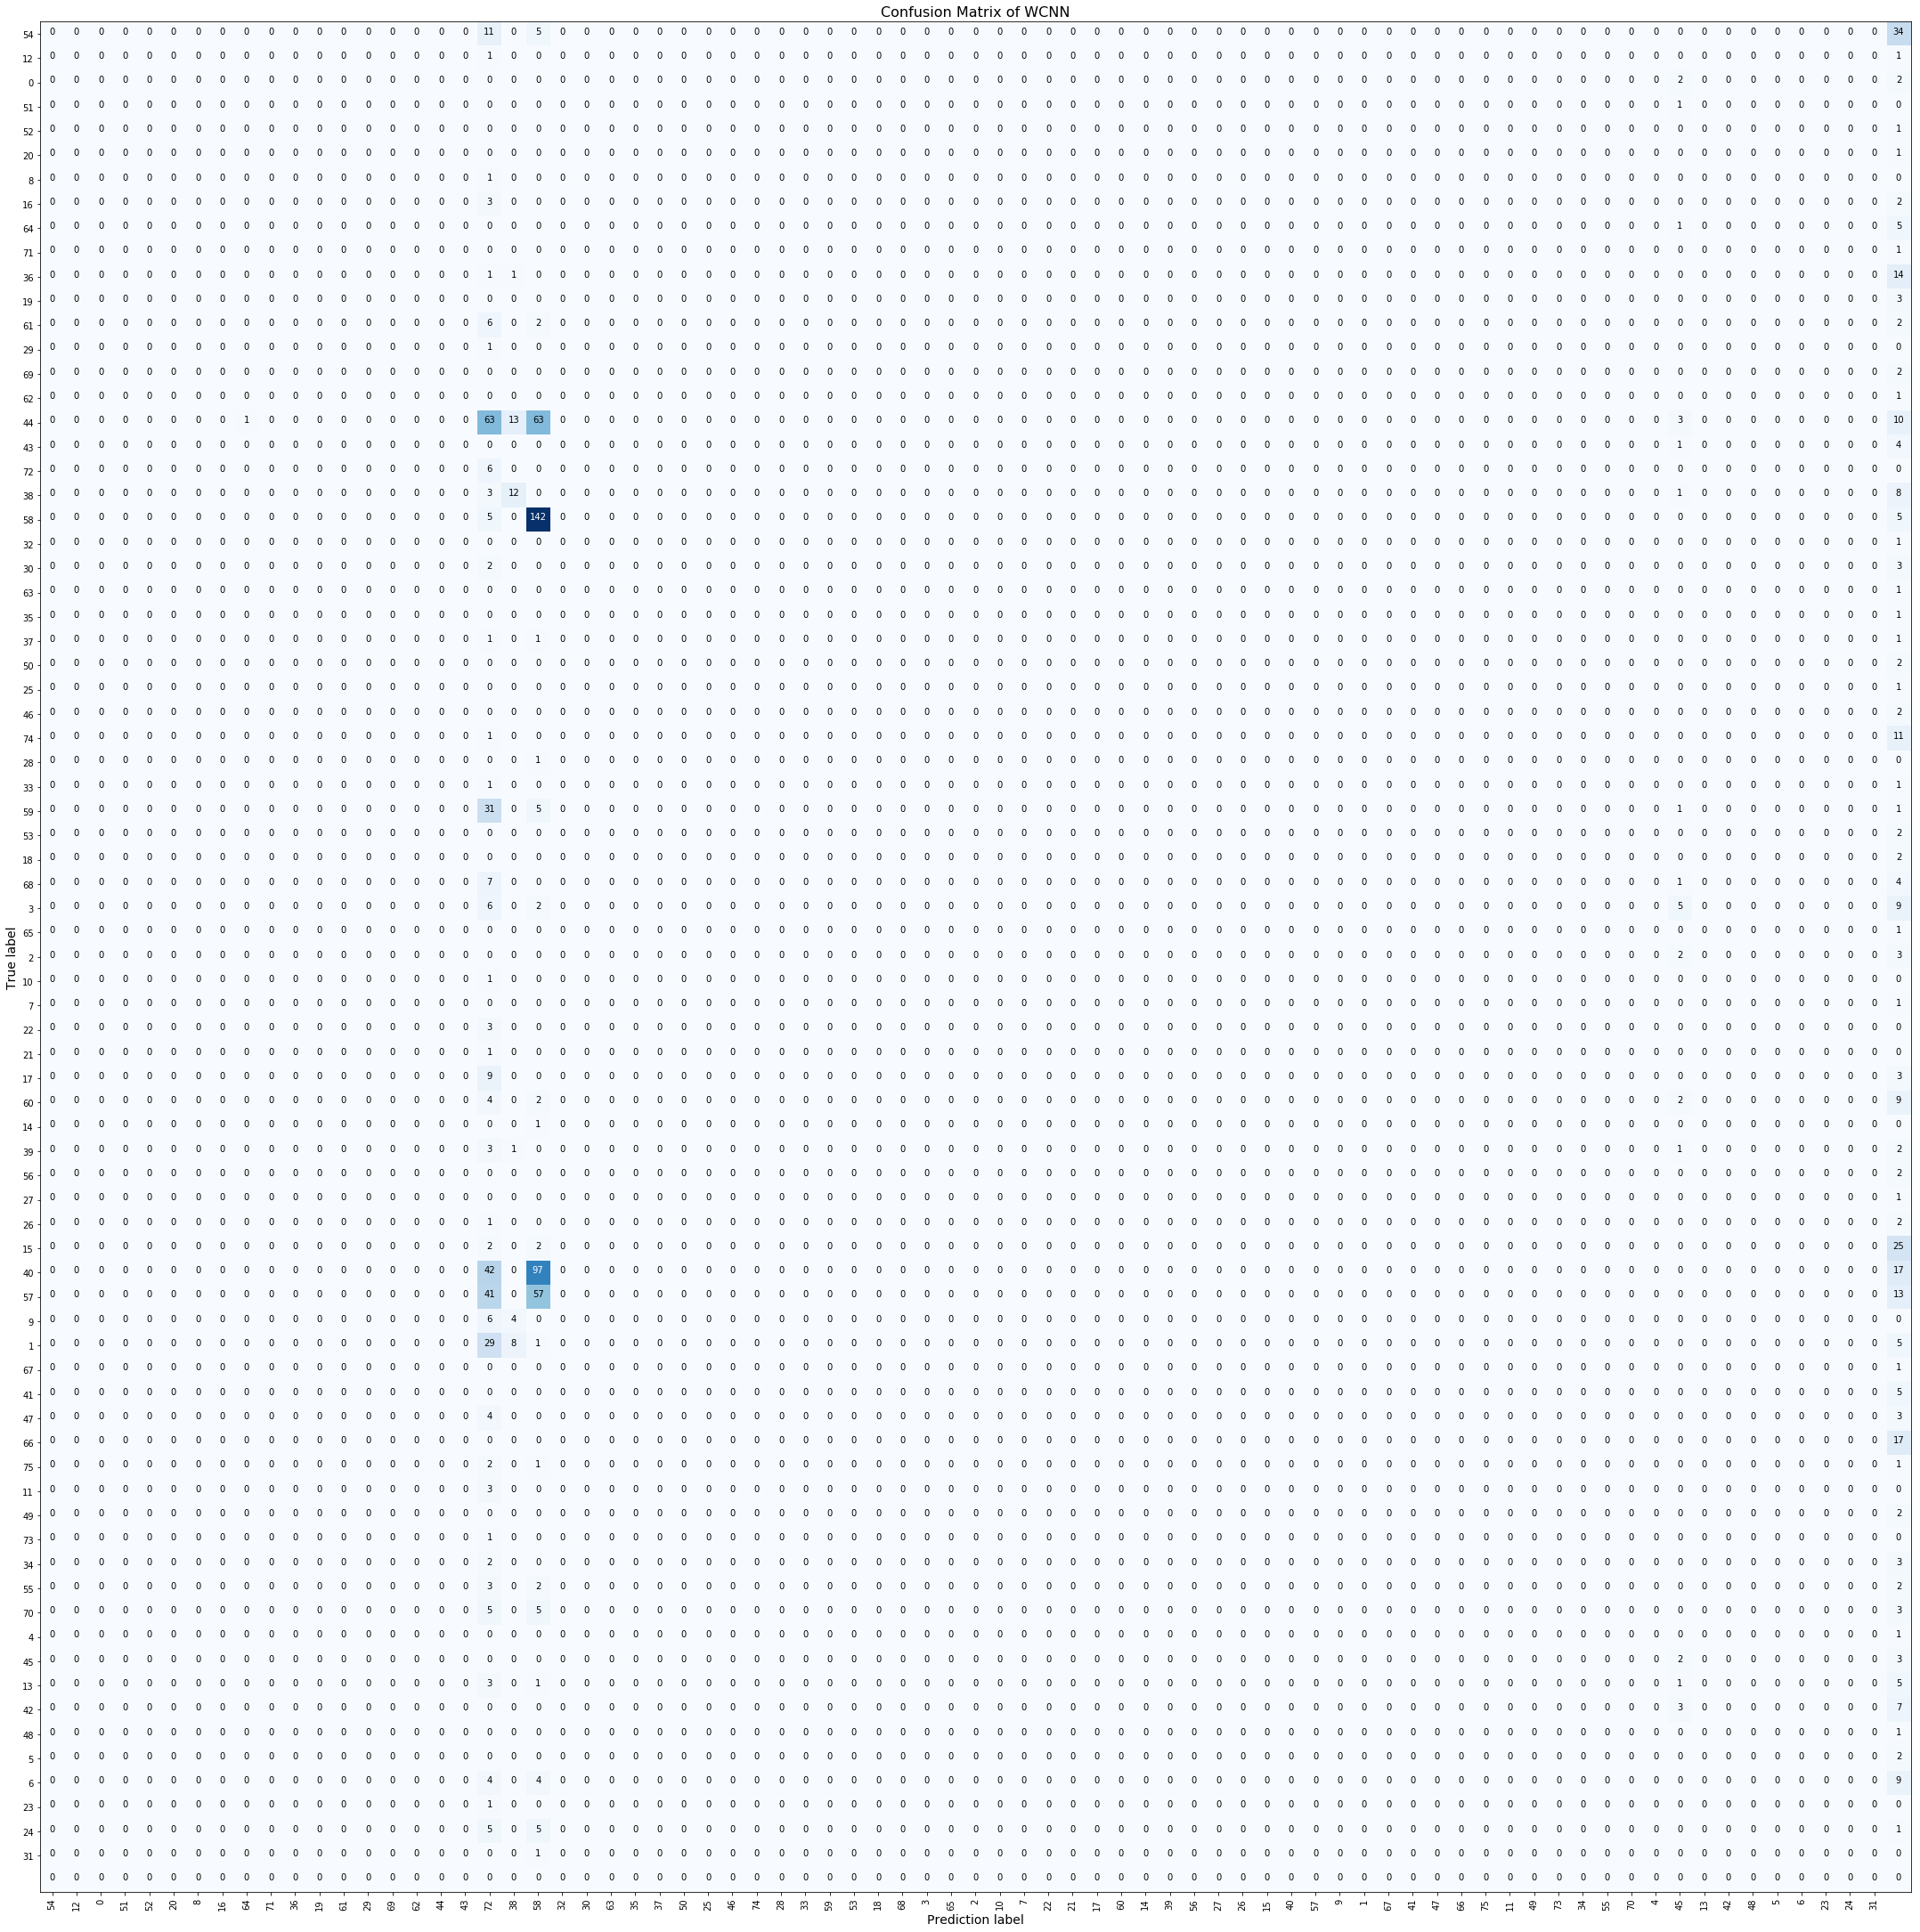

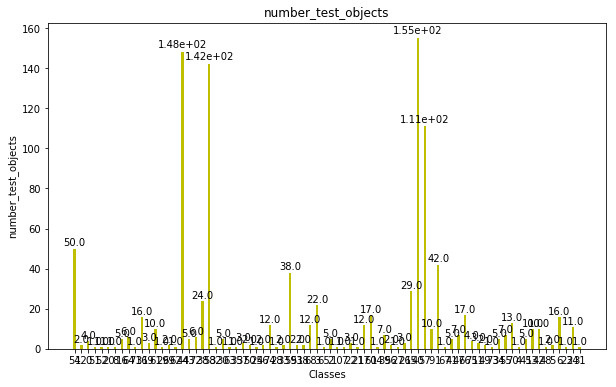

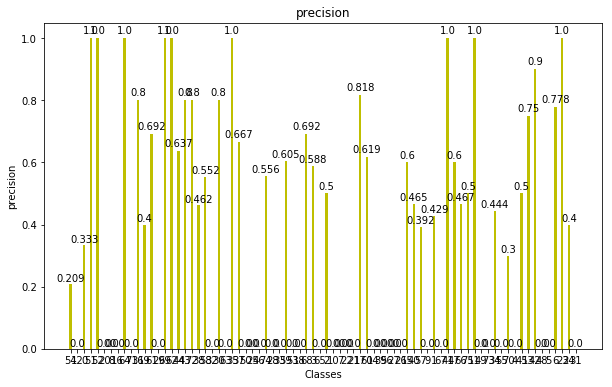

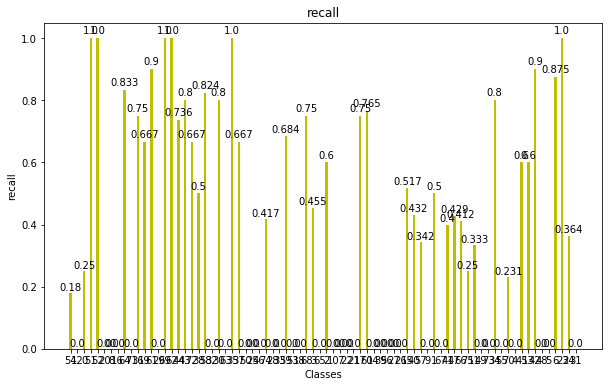

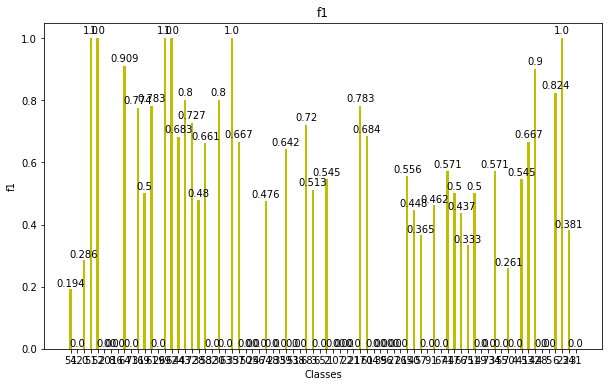

In [4]:
Manager = PipelineManager(language, dataset_name, emb_name, emb_dim, hyper_search=False)
Manager.run(linear_pipe, linear_struct, 'linear', pure_data)
Manager.run(neural_pipe, neural_struct, 'neural', pure_data)